# **I.** Data Load
`class PyG.Data` Attributers:  
* `x`: 그래프의 노드 특성(feature)을 나타내는 텐서  

* `y`: 노드 또는 엣지의 타깃(레이블)을 나타내는 텐서  
* `edge_index`: 그래프의 엣지를 나타내는 텐서  
* `train_mask`, `val_mask`, `test_mask`: 각 노드의 훈련, 검증, 테스트 마스크를 나타내는 텐서  

In [1]:
# Load PubMed Dataset from the Planetoid class and Print some inf' about the graph
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

print(f"Dataset: {dataset}")
print('-' * 30)
print(f"Num of Graphs   : {len(dataset)}")
print(f"Num of Nodes    : {data.x.shape[0]}")
print(f"Num of Features : {dataset.num_features}")
print(f"Num of classes  : {dataset.num_classes}")

print()

print("Graph:")
print('-' * 30)
print(f"Training Nodes : {sum(data.train_mask).item()}")
print(f"Evaluation Nodes : {sum(data.val_mask).item()}")
print(f"Test Nodes : {sum(data.test_mask).item()}")
print(f"Edges are directed : {data.is_directed()}")
print(f"Graph has isolated nodes : {data.has_isolated_nodes()}")
print(f"Graph has loops : {data.has_self_loops()}")

Dataset: Pubmed()
------------------------------
Num of Graphs   : 1
Num of Nodes    : 19717
Num of Features : 500
Num of classes  : 3

Graph:
------------------------------
Training Nodes : 60
Evaluation Nodes : 500
Test Nodes : 1000
Edges are directed : False
Graph has isolated nodes : False
Graph has loops : False


# **II.** Neighbor Sampling

In [2]:
# Nbd Sampling by NeighorLoader class
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],
    batch_size=16,
    input_nodes=data.train_mask
)

for i, subgraph in enumerate(train_loader):
    print(f"Subgraph {i}: {subgraph}")

Subgraph 0: Data(x=[510, 500], edge_index=[2, 617], y=[510], train_mask=[510], val_mask=[510], test_mask=[510], n_id=[510], e_id=[617], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[285, 500], edge_index=[2, 370], y=[285], train_mask=[285], val_mask=[285], test_mask=[285], n_id=[285], e_id=[370], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[372, 500], edge_index=[2, 451], y=[372], train_mask=[372], val_mask=[372], test_mask=[372], n_id=[372], e_id=[451], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[232, 500], edge_index=[2, 293], y=[232], train_mask=[232], val_mask=[232], test_mask=[232], n_id=[232], e_id=[293], input_id=[12], batch_size=12)


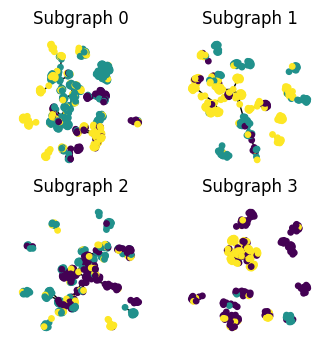

In [3]:
# Visualize Nbd sampling results
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig = plt.figure(figsize=(4, 4))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f"Subgraph {idx}", fontsize=12)
    plt.axis("off")
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=0),
        with_labels=False,
        node_color=subdata.y,
        node_size=15
    )
plt.show()

# **III.** Architectures

In [4]:
# Modules
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [5]:
# Evaluate
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

## Transductive learning
`out = self(batch.x, batch.edge_index)`  
: 전체 그래프를 forward한다는 점에서 transductive

`loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])`  
: 학습 과정(loss function 계산과 역전파)에서는 train data만 사용

In [6]:
# GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, aggr='mean'):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h, aggr=aggr)
        self.relu = torch.nn.ReLU()
        self.sage2 = SAGEConv(dim_h, dim_out, aggr=aggr)
    
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = self.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, epochs):
        log = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.train()
        for epoch in range(epochs+1):
            train_loss, val_loss, train_acc, val_acc = 0, 0, 0, 0
            for batch in train_loader:
                optimizer.zero_grad()
                
                out = self(batch.x, batch.edge_index)  
                # Equal to `self.forward(batch.x, batch.edge_index)`
                # Transitive (See all graph)

                # Train

                # Use only train dataset
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                train_loss += loss
                train_acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])

                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
            
            n = len(train_loader)
            log['train_loss'].append(float(train_loss / n))
            log['train_acc'].append(train_acc/n)
            log['val_loss'].append(float(val_loss/n))
            log['val_acc'].append(val_acc/n)

            if epoch % 20 == 0:
                echo = [f"Epoch {epoch:>3}"]
                for metric in log:
                    echo.append(f"{metric}: {log[metric][-1]:.3f}")
                print(" | ".join(echo))
                
        return log
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# **IV.** Learning

## Train

In [7]:
# Options
epochs = 100
aggregations = ['mean', 'max', 'median', 'var', 'std']#, 'lstm']

In [8]:
# Create Model Instacnes
models = {}
for aggr in aggregations:
    models[aggr] = GraphSAGE(dim_in=dataset.num_features, dim_h=64, dim_out=dataset.num_classes, aggr=aggr)

In [9]:
# Fits
logs = {}
for aggr in aggregations:
    print(f"GraphSAGE with {aggr} aggregation")
    logs[aggr] = models[aggr].fit(epochs=epochs)
    print()

GraphSAGE with mean aggregation
Epoch   0 | train_loss: 1.134 | train_acc: 0.230 | val_loss: 1.104 | val_acc: 0.289
Epoch  20 | train_loss: 0.006 | train_acc: 1.000 | val_loss: 0.712 | val_acc: 0.724
Epoch  40 | train_loss: 0.002 | train_acc: 1.000 | val_loss: 0.579 | val_acc: 0.747
Epoch  60 | train_loss: 0.001 | train_acc: 1.000 | val_loss: 0.542 | val_acc: 0.736
Epoch  80 | train_loss: 0.001 | train_acc: 1.000 | val_loss: 0.559 | val_acc: 0.782
Epoch 100 | train_loss: 0.000 | train_acc: 1.000 | val_loss: 0.719 | val_acc: 0.681

GraphSAGE with max aggregation
Epoch   0 | train_loss: 1.194 | train_acc: 0.227 | val_loss: 1.128 | val_acc: 0.154
Epoch  20 | train_loss: 0.009 | train_acc: 1.000 | val_loss: 0.804 | val_acc: 0.670
Epoch  40 | train_loss: 0.003 | train_acc: 1.000 | val_loss: 0.762 | val_acc: 0.673
Epoch  60 | train_loss: 0.001 | train_acc: 1.000 | val_loss: 0.900 | val_acc: 0.676
Epoch  80 | train_loss: 0.000 | train_acc: 1.000 | val_loss: 0.601 | val_acc: 0.707
Epoch 100 | 

## Test

In [10]:
# Inference
print("\033[34mAccuracies of GraphSAGE models\033[0m")
print("-" * 30)
for aggr in aggregations:
    acc = models[aggr].test(data)
    print(f"Aggregation with \033[3m{aggr.upper():6}\033[0m : {acc:.3f}")

Accuracies of GraphSAGE models
------------------------------
Aggregation with MEAN   : 0.761
Aggregation with MAX    : 0.775
Aggregation with MEDIAN : 0.737
Aggregation with VAR    : 0.706
Aggregation with STD    : 0.710


# **V.** Visualize training logs

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [12]:
def visualize(log, aggr):
    train_losses = log['train_loss']
    val_losses = log['val_loss']
    train_acc = log['train_acc']
    val_acc = log['val_acc']
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    plt.suptitle(f'GrahpSAGE with {aggr.upper()} Aggregation', fontweight='bold')

    # Loss subplot
    axes[0].plot(epochs, train_losses, label='Train Loss')
    axes[0].plot(epochs, val_losses, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].legend()

    # Accuracy subplot
    axes[1].plot(epochs, train_acc, label='Train Accuracy')
    axes[1].plot(epochs, val_acc, label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].legend()

    plt.tight_layout()
    plt.show()

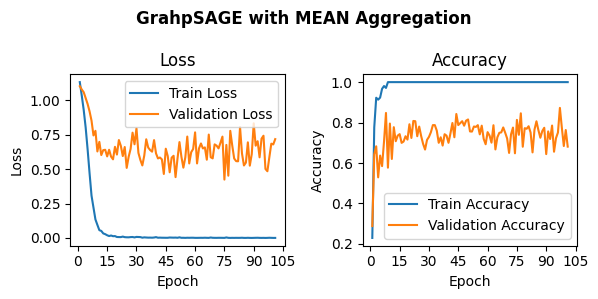

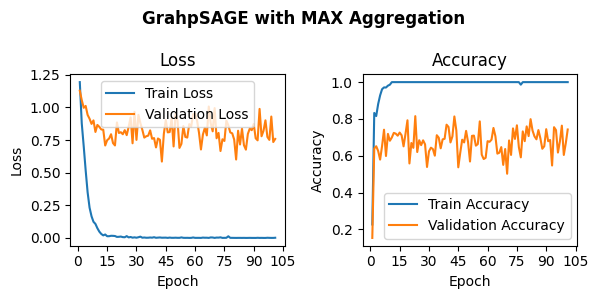

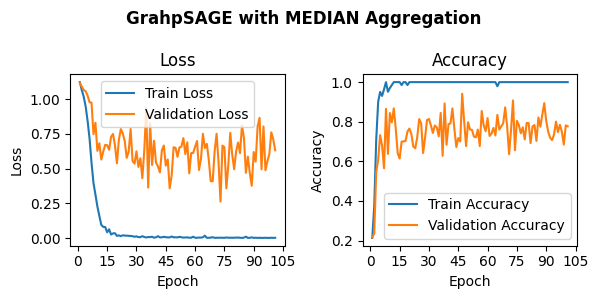

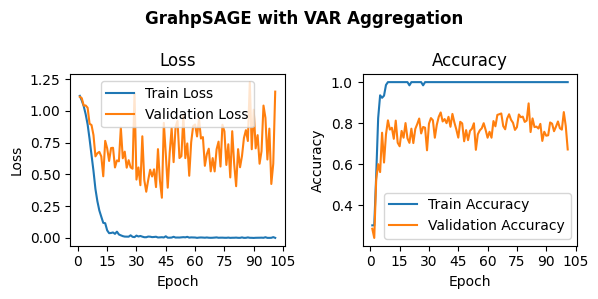

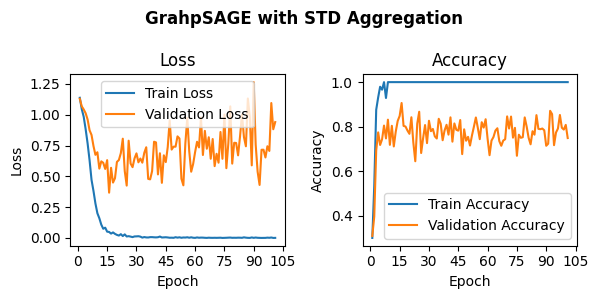

In [13]:
for aggr in aggregations:
    visualize(logs[aggr], aggr)